In [1]:
import plotly.express as px

from crawler.utils import read_bookings_csv

In [2]:
bookings = read_bookings_csv('data/bookings.csv', 'data/shorts.txt')
bookings.tail()

,library,day,period_start,period_end,bookable,offset
timestamp,,,,,,
2022-01-24 21:40:06+01:00,Mathematics & Informatics,2022-01-25,0 days 15:00:00,0 days 21:30:00,False,-1 days +21:40:00
2022-01-24 21:40:06+01:00,Physics,2022-01-25,0 days 10:00:00,0 days 17:45:00,False,-1 days +21:40:00
2022-01-24 21:40:06+01:00,Life Sciences,2022-01-25,0 days 08:00:00,0 days 14:30:00,True,-1 days +21:40:00
2022-01-24 21:40:06+01:00,Life Sciences,2022-01-25,0 days 15:00:00,0 days 21:30:00,True,-1 days +21:40:00
2022-01-24 21:40:06+01:00,Renewable Resources,2022-01-25,0 days 10:00:00,0 days 17:45:00,True,-1 days +21:40:00


In [3]:
libraries = bookings.library.unique().tolist()
libraries

['Main Campus',
 'Mathematics & Informatics',
 'Life Sciences',
 'Medicine',
 'Chemistry',
 'Mechanical Engineering',
 'Physics',
 'Renewable Resources']

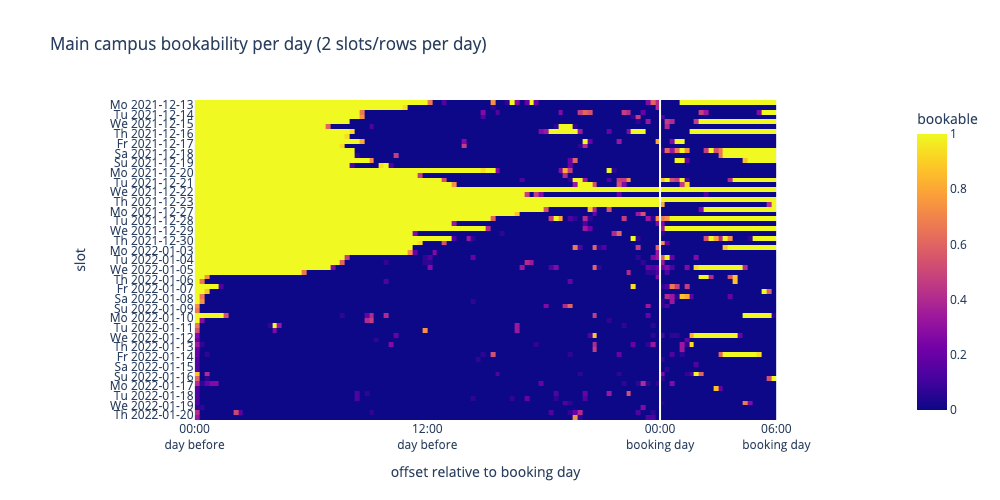

In [4]:
# Visualize bookings relative to booking day.

resample_mins = 15
full_values = 1800 / resample_mins

matrix = []

library_bookings = bookings[bookings.library == libraries[0]]
slots = library_bookings[['day', 'period_start', 'period_end']].drop_duplicates().values

valid_slots = []

for day, period_start, _ in slots:
    slot_bookings = library_bookings[
        (library_bookings.day == day) & (library_bookings.period_start == period_start)
    ]
    bookable = (
        slot_bookings.bookable.groupby(slot_bookings.offset)
        .mean()
        .resample(f'{resample_mins}min')
        .mean()
    )

    if bookable.count() != full_values:
        continue

    matrix.append(bookable.values)
    valid_slots.append((day, period_start))

fig = px.imshow(
    matrix,
    labels=dict(x='offset relative to booking day', y='slot', color='bookable'),
    title='Main campus bookability per day (2 slots/rows per day)',
)
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=[
            -0.5,
            2 * full_values // 5 - 0.5,
            4 * full_values // 5 - 0.5,
            full_values - 0.5,
        ],
        ticktext=[
            '00:00<br>day before',
            '12:00<br>day before',
            '00:00<br>booking day',
            '06:00<br>booking day',
        ],
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=[i + 0.5 for i in range(len(matrix))],
        ticktext=[
            f'{day.day_name()[:2]} {day.date()}'
            if period_start.seconds < 12 * 3600
            else ' '
            for day, period_start in valid_slots
        ],
    ),
    width=1000,
)

fig.add_vline(4 * full_values // 5 - 0.5, line_color='white', line_width=2)
fig.show('png')  # visibility in github
# fig  # visibility in vscode